In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix

# File paths
dga_file = "/home/ubuntu/DoH_DGA_training/datasets/DGA/all_pcaps_allN.csv"
tunnel_file = "/home/ubuntu/DoH_DGA_training/datasets/DoH_HKD/DoH-Pcaps/all_pcaps_allN.csv"

# Load datasets
df_dga = pd.read_csv(dga_file)
df_tunnel = pd.read_csv(tunnel_file)

# Assign labels
df_dga["label"] = "DGA"
df_tunnel["label"] = "tunnel"

print("DGA shape:", df_dga.shape)
print("Tunnel shape:", df_tunnel.shape)

# Print columns to confirm structure
print("Columns:\n", list(df_dga.columns))


DGA shape: (9012, 25)
Tunnel shape: (6008, 26)
Columns:
 ['session_id', 'client_ip', 'server_ip', 'client_port', 'server_port', 'protocol', 'N', 'n_client', 'client_bytes', 'client_pkt_min', 'client_pkt_mean', 'client_pkt_max', 'client_iat_min', 'client_iat_mean', 'client_iat_max', 'n_server', 'server_bytes', 'server_pkt_min', 'server_pkt_mean', 'server_pkt_max', 'server_iat_min', 'server_iat_mean', 'server_iat_max', 'bytes_ratio', 'label']


In [4]:
# Concatenate into one dataframe
final_df = pd.concat([df_dga, df_tunnel], ignore_index=True)

print("Final dataset shape:", final_df.shape)
print(final_df["label"].value_counts())

# Separate features and target
y = final_df["label"]
X = final_df.drop(columns=["label", 'session_id', 'client_ip', 'server_ip', 'client_port', 'server_port', 'protocol'])

# Keep only numeric features
X = X.select_dtypes(include=["int64", "float64"])

print("Features shape:", X.shape)


Final dataset shape: (15020, 26)
label
DGA       9012
tunnel    6008
Name: count, dtype: int64
Features shape: (15020, 18)


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report
import numpy as np

# --- Assume you already have your dataset loaded as X, y ---
# Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y)
print("Classes:", le.classes_)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

# Scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

Classes: ['DGA' 'tunnel']


### MLP training

In [14]:
from skorch import NeuralNetClassifier
from sklearn.inspection import permutation_importance

# Wrap the MLP model
net = NeuralNetClassifier(
    MLP,
    module__input_dim=X_train.shape[1],
    module__num_classes=len(le.classes_),
    max_epochs=10,
    lr=0.001,
    optimizer=optim.Adam,
    criterion=nn.CrossEntropyLoss,
    device='cpu'   # or 'cuda'
)

# Fit like sklearn
net.fit(X_train, y_train)
preds = net.predict(X_test)

print("Classification report:\n")
print(classification_report(y_test, preds, target_names=le.classes_))


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.3116       0.9908        0.0406  3.0452
      2        0.0203       0.9942        0.0180  3.0287
      3        0.0076       0.9979        0.0141  3.0169
      4        0.0046       0.9979        0.0102  3.0019
      5        0.0031       0.9983        0.0060  3.0204
      6        0.0021       0.9992        0.0026  3.0389
      7        0.0012       0.9996        0.0016  3.0156
      8        0.0008       0.9996        0.0013  3.0372
      9        0.0006       0.9996        0.0010  3.0154
     10        0.0004       1.0000        0.0008  3.0365
Classification report:

              precision    recall  f1-score   support

         DGA       1.00      1.00      1.00      1802
      tunnel       1.00      1.00      1.00      1202

    accuracy                           1.00      3004
   macro avg       1.00      1.00      1.00      3004
weighted avg       1

### Features analysis

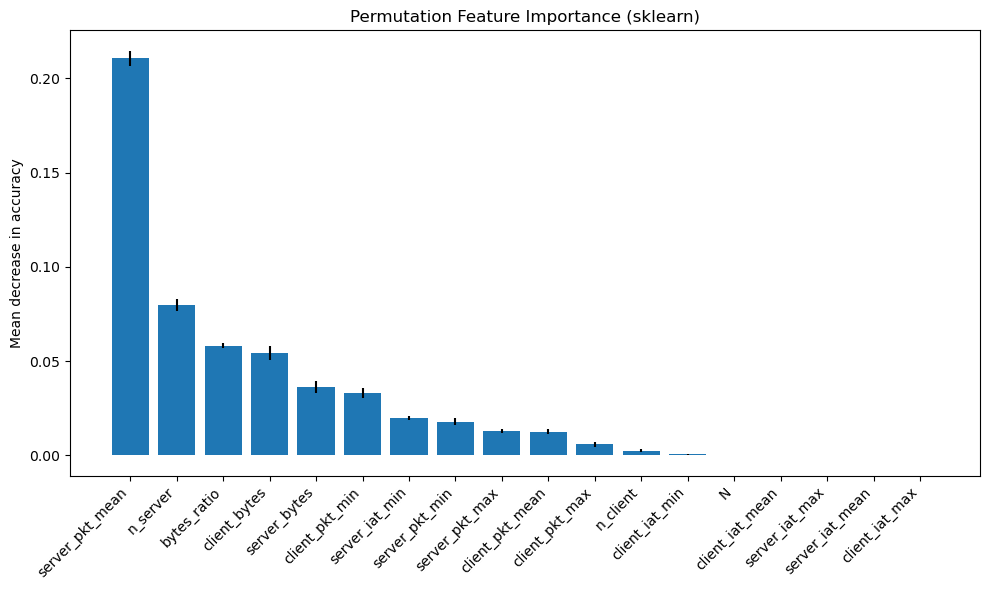

In [18]:
perm_result = permutation_importance(
    net,
    X_test,   # must be numpy, not torch
    y_test, 
    n_repeats=10,
    random_state=42,
    scoring="accuracy"
)

import matplotlib.pyplot as plt
import numpy as np

# Get importance means and std dev
importances = perm_result.importances_mean
std = perm_result.importances_std

# Feature names (if you have them, else fallback to generic)
try:
    feature_names = X.columns  # if X is a pandas DataFrame
except:
    feature_names = [f"f{i}" for i in range(X_test.shape[1])]

# Sort features by importance
indices = np.argsort(importances)[::-1]

# Plot
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[indices], yerr=std[indices], align="center")
plt.xticks(range(len(importances)), np.array(feature_names)[indices], rotation=45, ha="right")
plt.title("Permutation Feature Importance (sklearn)")
plt.ylabel("Mean decrease in accuracy")
plt.tight_layout()
plt.show()


In [25]:
# --- SHAP with KernelExplainer (NumPy inputs) ---
import shap
def predict_fn(x_numpy):
    x_t = torch.tensor(x_numpy, dtype=torch.float32)
    with torch.no_grad():
        out = raw_model(x_t)
        return out.numpy()   # logits; can also use softmax if you prefer probs

# Convert background and test samples to numpy
background = X_train[:200] if isinstance(X_train, np.ndarray) else X_train.numpy()[:200]
test_samples = X_test[:100] if isinstance(X_test, np.ndarray) else X_test.numpy()[:100]

explainer = shap.KernelExplainer(predict_fn, background)
shap_values = explainer.shap_values(test_samples)

print("SHAP values shape:", np.array(shap_values).shape)

# shap_values is a list [array_for_class0, array_for_class1]
print("Classes:", le.classes_)

# Pick class 0
shap.summary_plot(shap_values[0], test_samples, feature_names=feature_names)


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 100/100 [00:34<00:00,  2.91it/s]

SHAP values shape: (100, 18, 2)
Classes: ['DGA' 'tunnel']



/tmp/ipykernel_66196/1740457562.py:22: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[0], test_samples, feature_names=feature_names)


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

<Figure size 640x480 with 0 Axes>

In [ ]:
# --- Integrated Gradients with Captum ---
ig = IntegratedGradients(raw_model)

sample = torch.tensor(X_test[0:1], dtype=torch.float32)
attr, delta = ig.attribute(sample, target=int(y_test[0]), return_convergence_delta=True)

print("Integrated Gradients attribution for first test sample:")
print(attr.detach().numpy())
print("Convergence delta:", delta.item())

### Adversarial FGSM

In [16]:
# --- FGSM Attack ---
def fgsm_attack(model, x, y, epsilon, target_class=None):
    x_adv = x.clone().detach().requires_grad_(True)
    outputs = model(x_adv)

    # Targeted: force DGA -> Tunnel
    if target_class is not None:
        y_target = torch.full_like(y, target_class)
        loss = criterion(outputs, y_target)
    else:
        loss = criterion(outputs, y)

    model.zero_grad()
    loss.backward()

    perturbation = epsilon * x_adv.grad.sign()
    x_adv = x_adv + perturbation
    return torch.clamp(x_adv, -5, 5).detach()  # keep in a valid range

# Get only DGA samples from test set
dga_label = np.where(le.classes_ == "DGA")[0][0]
dga_idx = (y_test == dga_label).nonzero().squeeze()
X_dga = X_test[dga_idx]
y_dga = y_test[dga_idx]

In [21]:
# Get label indices
dga_label = le.transform(["DGA"])[0]
tunnel_label = le.transform(["tunnel"])[0]

# Extract only DGA samples
dga_idx = (y_test == dga_label).nonzero().squeeze()
X_dga = X_test[dga_idx]
y_dga = y_test[dga_idx]

# Untargeted attack first
X_dga_adv = fgsm_attack(model, X_dga, y_dga, epsilon=0.2, target_class=None)

adv_preds = model(X_dga_adv).argmax(dim=1)

flip_rate = (adv_preds != y_dga).float().mean().item()
print(f"Untargeted FGSM flip rate (DGA misclassified): {flip_rate:.2%}")


Untargeted FGSM flip rate (DGA misclassified): 12.20%


In [22]:
for eps in [0.1, 0.2, 0.5, 1.0]:
    X_dga_adv = fgsm_attack(model, X_dga, y_dga, epsilon=eps, target_class=tunnel_label)
    adv_preds = model(X_dga_adv).argmax(dim=1)
    success_rate = (adv_preds == tunnel_label).float().mean().item()
    print(f"Epsilon={eps}: Targeted success {success_rate:.2%}")


Epsilon=0.1: Targeted success 0.00%
Epsilon=0.2: Targeted success 0.00%
Epsilon=0.5: Targeted success 0.00%
Epsilon=1.0: Targeted success 0.00%


### PGD 

In [23]:
def pgd_attack(model, x, y, epsilon, alpha, iters, target_class=None):
    x_adv = x.clone().detach()
    for i in range(iters):
        x_adv.requires_grad_(True)
        outputs = model(x_adv)
        if target_class is not None:
            y_target = torch.full_like(y, target_class)
            loss = criterion(outputs, y_target)
        else:
            loss = criterion(outputs, y)
        model.zero_grad()
        loss.backward()
        with torch.no_grad():
            grad = x_adv.grad.sign()
            if target_class is not None:
                x_adv = x_adv - alpha * grad  # targeted → descend
            else:
                x_adv = x_adv + alpha * grad  # untargeted → ascend
            # Project into epsilon-ball
            perturb = torch.clamp(x_adv - x, min=-epsilon, max=epsilon)
            x_adv = torch.clamp(x + perturb, -5, 5)
    return x_adv.detach()


In [24]:
X_dga_adv = pgd_attack(model, X_dga, y_dga, epsilon=0.5, alpha=0.05, iters=40, target_class=tunnel_label)
adv_preds = model(X_dga_adv).argmax(dim=1)
success_rate = (adv_preds == tunnel_label).float().mean().item()
print("PGD targeted success:", success_rate)


PGD targeted success: 0.9312638640403748


In [25]:
import pandas as pd
import numpy as np
import torch

# --- 1. Generate PGD adversarial samples ---
X_dga_adv = pgd_attack(
    model, 
    X_dga, 
    y_dga, 
    epsilon=0.5, 
    alpha=0.05, 
    iters=40, 
    target_class=tunnel_label
)

# --- 2. Predictions on adversarial samples ---
adv_preds = model(X_dga_adv).argmax(dim=1)

# Convert to numpy for easier handling
X_dga_adv_np = X_dga_adv.detach().cpu().numpy()
adv_preds_np = adv_preds.detach().cpu().numpy()
y_dga_np = y_dga.detach().cpu().numpy()

# --- 3. Inverse transform to original feature scale ---
X_dga_adv_original = scaler.inverse_transform(X_dga_adv_np)
X_dga_original = scaler.inverse_transform(X_dga.detach().cpu().numpy())

# --- 4. Filter: only those that succeeded (predicted tunnel) ---
success_idx = np.where(adv_preds_np == tunnel_label)[0]

X_adv_success = X_dga_adv_original[success_idx]
X_orig_success = X_dga_original[success_idx]

# --- 5. Build a DataFrame with original vs adversarial ---
df_success = pd.DataFrame()

for i in range(X.shape[1]):  # for each feature
    df_success[f"orig_f{i}"] = X_orig_success[:, i]
    df_success[f"adv_f{i}"] = X_adv_success[:, i]

df_success["adv_prediction"] = le.inverse_transform(adv_preds_np[success_idx])

# --- 6. Print first few ---
print(df_success.head())

# --- 7. Save to CSV ---
df_success.to_csv("pgd_adversarial_success.csv", index=False)
print("Saved adversarial samples to pgd_adversarial_success.csv")


    orig_f0        adv_f0  orig_f1     adv_f1     orig_f2     adv_f2  orig_f3  \
0  208933.0  157772.78125     52.0  49.693684  102.922661  53.293518    646.0   
1  208933.0  157772.78125     52.0  49.693684  102.922661  53.293518    646.0   
2  209973.0  158812.78125     52.0  49.693684  102.425850  52.796715    646.0   
3  209037.0  157876.78125     52.0  49.693684  102.872536  53.243397    646.0   
4  208992.0  157831.78125     52.0  49.693684  102.901031  53.271896    646.0   

       adv_f3       orig_f4    adv_f4  ...   adv_f11  orig_f12   adv_f12  \
0  494.442169  9.536689e-07 -0.002086  ...  0.029968  0.025965 -2.339527   
1  494.442169  1.907343e-06 -0.002085  ...  0.029965  0.026937 -2.338555   
2  494.442169  1.907343e-06 -0.002085  ...  0.029965  0.027250 -2.338242   
3  494.442169  1.907343e-06 -0.002085  ...  0.029969  0.025561 -2.339931   
4  494.442169  2.145776e-06 -0.002084  ...  0.029965  0.021380 -2.344112   

    orig_f13      adv_f13  orig_f14   adv_f14  orig_f15 